# Transfer Learning
Not only can training a model from scratch can be time consuming and computationally heavy, in cases where we need to use a large model but we only have a small amount of data, overfitting is almost guaranteed to occur!
In this notebook we look at how we can take a network trained on one dataset and use the learned weights as a step up, allowing us to achieve good results with little effort.<br>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader as dataloader
import torchvision.models as models
import time
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import trange, tqdm

from Trainer import ModelTrainer

In [2]:
# The size of our mini batches
batch_size = 64

# How many itterations of our dataset
num_epochs = 10

# Optimizer learning rate
learning_rate = 1e-4

# Initialise what epoch we start from
start_epoch = 0

# Initialise best valid accuracy 
best_valid_acc = 0

# Where to load/save the dataset from 
data_set_root = "../../datasets"

# What to resize our images to 
image_size = 96

In [3]:
start_from_checkpoint = False

save_dir = '../data/Models'
model_name = 'ResNet18_STL10'

In [4]:
# Set device to GPU_indx if GPU is avaliable
GPU_indx = 0
device = torch.device(GPU_indx if torch.cuda.is_available() else 'cpu')

# Some preprocess to the dataset. eg: Convert the images to tensor

In [5]:
# Prepare a composition of transforms
# A ll models from the Pytorch model Zoo where trained using images normalised with 
# the mean and std (one per channel) of the whole ImageNet Dataset
# therefore the pretrained feature "detectors" of the model will expect the input to 
# be normalized in the same way 
# https://pytorch.org/docs/stable/torchvision/models.html
transform = transforms.Compose([transforms.Resize(image_size),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                     std=[0.229, 0.224, 0.225])]) 

# Create the training, testing and validation data 

In [6]:
# Define our STL10 Datasets
# https://pytorch.org/docs/stable/torchvision/datasets.html#torchvision.datasets.STL10

# Dataset definition is a bit different to MNIST and CIFAR10
# STL10 has 3 different datasets, test, train and unlabeled
# http://ai.stanford.edu/~acoates/stl10/
# training set only has 5000 images and test set only 8000
# Image size in this dataset are 96x96, larger then what we've been using

train_data = datasets.STL10(data_set_root, split='train', download=True, transform=transform)
test_data = datasets.STL10(data_set_root, split='test', download=True, transform=transform)

# Split training data into train and validation set with 90/10% training/validation split
validation_split = 0.9

n_train_examples = int(len(train_data)*validation_split)
n_valid_examples = len(train_data) - n_train_examples
train_data, valid_data = torch.utils.data.random_split(train_data, [n_train_examples, n_valid_examples],
                                                       generator=torch.Generator().manual_seed(42))

# Create the pretrained network
First train the [ResNet](https://arxiv.org/pdf/1512.03385.pdf) from scratch and collect the results for the training and evaluation accuracy and training time<br>
Next set pretrained=True and train again collecting the results again <br>
Next uncomment out the commented lines of code, this will stop the optimiser from updating the pretrained parts of the network 
<br><br>
<b> Weight "Freezing"</b>
<br>
By "freezing" parts of the network like this we can speed up the training of the model as we will only be updating a single layer, this is especially useful if our pretrained model is very big (note we still have to do a full forward pass of the model which might take a while)<br>
We can "freeze" the early layers of the model like this because the ImageNet dataset that the model was trained on has similar images, and will have similar features to the STL10 dataset we are using. Because of this the features in the images that the network would need to learn to detect, would be similar between datasets<br>
NOTE if our dataset is very different to the ImageNet dataset "freezing" parts of the model might not be effective <br>
Once we have trained our single layer for a while we can then unfreeze the rest of our model and train the whole thing for a few epochs to refine the model for our dataset

Use Pytorch's implementation of [ResNet18](https://pytorch.org/vision/0.14/models.html) with both randomly initialised weights and pretrained weights.

In [7]:
# Create a ResNet18 from the pytorch "models" module
# This is reasonably sized model at 18 layers deep
# ResNet Paper https://arxiv.org/pdf/1512.03385.pdf

# Create an instance of the ResNet18 Model
res_net = models.resnet18(pretrained=False).to(device) # To Do

/home/scrocha/projetos/pytorch-studies/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/scrocha/projetos/pytorch-studies/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [8]:
# Uncomment this when ready
# Loop through all the learnable parameter objects (from the layers)
# for param in res_net.parameters():
# # Set to True to unfreeze layers
#     param.requires_grad = False

The ImageNet challange dataset that the ResNet model was trained on has 1000 classes but the STL10 dataset only has 10 <br>
We can still use the pretrained model we just need to alter it a bit by simply replacing the last FC (linear) layer with a new one 

In [9]:
# Augment the model, by swapping out the last fc layer for a different one
# get the number of in_features into the last fc layer
num_ftrs = res_net.fc.in_features

# Redefine the last fc layer with a linear layer with 10 ouputs, 
# this layer's weights will be randomly initialised
res_net.fc = nn.Linear(num_ftrs, 10).to(device)

In [10]:
model_trainer = ModelTrainer(model=res_net, device=device, loss_fun=nn.CrossEntropyLoss(), 
                             batch_size=batch_size, learning_rate=learning_rate, 
                             save_dir=save_dir, model_name=model_name, 
                             start_from_checkpoint=start_from_checkpoint)

ValueError: Warning Checkpoint exists

In [ ]:
model_trainer.set_data(train_set=train_data, test_set=test_data, val_set=valid_data)

Number of training examples: 4500
Number of validation examples: 500
Number of testing examples: 8000


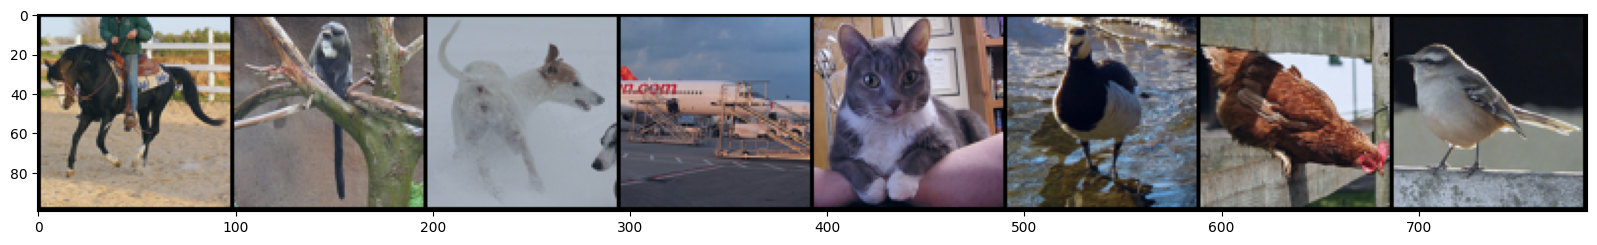

In [ ]:
plt.figure(figsize = (20,10))
images, labels = next(iter(model_trainer.test_loader))
out = torchvision.utils.make_grid(images[0:8], normalize=True)
_ = plt.imshow(out.numpy().transpose((1, 2, 0)))

In [ ]:
# Lets see how many Parameter's our Model has!
num_params = 0
for param in model_trainer.model.parameters():
    num_params += param.flatten().shape[0]
print("This model has %d (approximately %d Million) Parameters!" % (num_params, num_params//1e6))

This model has 11181642 (approximately 11 Million) Parameters!


In [ ]:
# This cell implements our training loop
# Record the start time
start_time = time.time()
valid_acc = 0
train_acc = 0

pbar = trange(start_epoch, num_epochs, leave=False, desc="Epoch")    
for epoch in pbar:
    pbar.set_postfix_str('Accuracy: Train %.2f%%, Val %.2f%%' % (train_acc * 100, valid_acc * 100))
    
    # Call the training function and pass training dataloader etc
    model_trainer.train_model()
    
    # Call the modules evaluate function for train and validation set
    train_acc = model_trainer.evaluate_model(train_test_val="train")
    valid_acc = model_trainer.evaluate_model(train_test_val="val")
    
    # Check if the current validation accuracy is greater than the previous best
    # If so, then save the model
    if valid_acc > model_trainer.best_valid_acc:
        model_trainer.save_checkpoint(epoch, valid_acc)

end_time = time.time()

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/71 [00:00<?, ?it/s]

Evaluating Train Set:   0%|          | 0/71 [00:00<?, ?it/s]

Evaluating Validation Set:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/71 [00:00<?, ?it/s]

Evaluating Train Set:   0%|          | 0/71 [00:00<?, ?it/s]

Evaluating Validation Set:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/71 [00:00<?, ?it/s]

Evaluating Train Set:   0%|          | 0/71 [00:00<?, ?it/s]

Evaluating Validation Set:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/71 [00:00<?, ?it/s]

Evaluating Train Set:   0%|          | 0/71 [00:00<?, ?it/s]

Evaluating Validation Set:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/71 [00:00<?, ?it/s]

Evaluating Train Set:   0%|          | 0/71 [00:00<?, ?it/s]

Evaluating Validation Set:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/71 [00:00<?, ?it/s]

Evaluating Train Set:   0%|          | 0/71 [00:00<?, ?it/s]

Evaluating Validation Set:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/71 [00:00<?, ?it/s]

Evaluating Train Set:   0%|          | 0/71 [00:00<?, ?it/s]

Evaluating Validation Set:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/71 [00:00<?, ?it/s]

Evaluating Train Set:   0%|          | 0/71 [00:00<?, ?it/s]

Evaluating Validation Set:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/71 [00:00<?, ?it/s]

Evaluating Train Set:   0%|          | 0/71 [00:00<?, ?it/s]

Evaluating Validation Set:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/71 [00:00<?, ?it/s]

Evaluating Train Set:   0%|          | 0/71 [00:00<?, ?it/s]

Evaluating Validation Set:   0%|          | 0/8 [00:00<?, ?it/s]

In [ ]:
print("The highest validation accuracy was %.2f%%" %(model_trainer.best_valid_acc*100))

The highest validation accuracy was 49.80%


In [ ]:
print("Training time %.2f seconds" %(end_time - start_time))

Training time 80.58 seconds


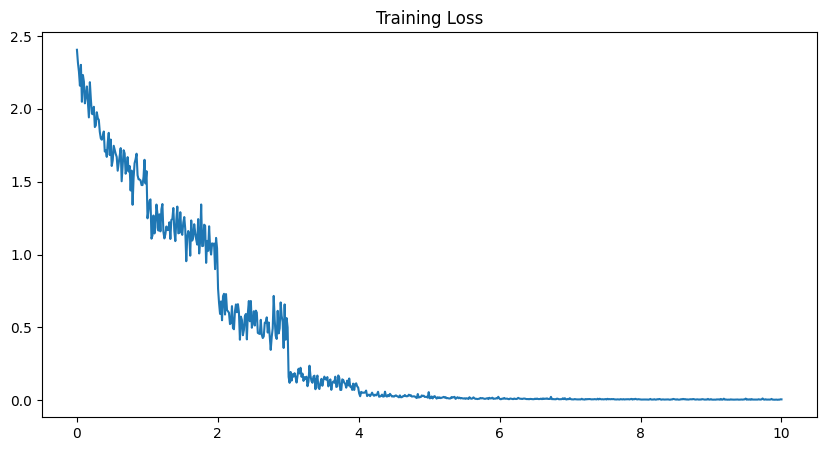

In [ ]:
_ = plt.figure(figsize = (10,5))
train_x = np.linspace(0, num_epochs, len(model_trainer.train_loss_logger))
_ = plt.plot(train_x, model_trainer.train_loss_logger)
_ = plt.title("Training Loss")

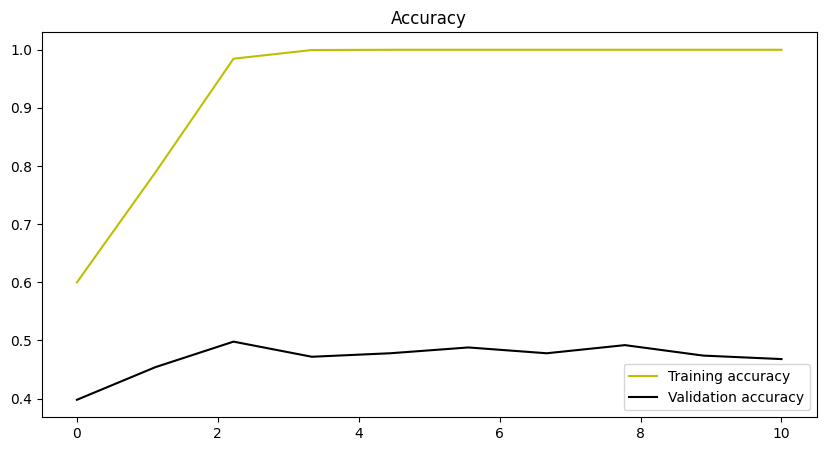

In [ ]:
_ = plt.figure(figsize = (10,5))
train_x = np.linspace(0, num_epochs, len(model_trainer.train_acc_logger))
_ = plt.plot(train_x, model_trainer.train_acc_logger, c = "y")
valid_x = np.linspace(0, num_epochs, len(model_trainer.val_acc_logger))
_ = plt.plot(valid_x, model_trainer.val_acc_logger, c = "k")

_ = plt.title("Accuracy")
_ = plt.legend(["Training accuracy", "Validation accuracy"])

# Evaluate

In [ ]:
# Call the evaluate function and pass the evaluation/test dataloader etc
test_acc = model_trainer.evaluate_model(train_test_val="test")
print("The Test Accuracy is: %.2f%%" %(test_acc*100))

Evaluating Test Set:   0%|          | 0/125 [00:00<?, ?it/s]

The Test Accuracy is: 49.54%
